# Preparação do ambiente

## Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import warnings

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from os import path as osp
from tqdm.auto import tqdm
from unicodedata import normalize
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Constantes e funções auxiliares

In [2]:
FILE_LABELS_RESULTS = '../datasets/samples_labeling/issues_fiscaliza/20240423/results/labels.parquet'

In [3]:
def clean_text(doc, return_tokens=False, nltk_tokenizer=True):

    stop_words = stopwords.words('portuguese')
    stop_words.extend(stopwords.words('english'))
    stop_words.extend(list(string.punctuation))
    
    # stopwords específicas do domínio
    # stop_words.extend(['cm', 'feature', 'features', 'informações', 'itens', 'leve', 'list', 'nulo', 'package', 'pacote', 'pacotes', 'recurso', 'tamanho', 'ver'])
    # remover da lista de stopwords a palavra sem para formar o bigrama "sem fio", relevante para o domínio
    # primeira rodada de classificação demonstrou que não foi uma boa escolha
    # testes nessa rodada confirmaram que não faz difença
    # stop_words.remove('sem')
    
    doc = doc.lower()

    # normalize docs
    doc = normalize('NFKD', doc).encode('ASCII', 'ignore').decode('ASCII')
    # normalize stopwords
    stop_words = [normalize('NFKD', word).encode('ASCII', 'ignore').decode('ASCII') for word in stop_words]
    
    # word regularization
    # wi-fi
    pattern = 'wi.fi'
    doc = re.sub(pattern, 'wifi', doc)
    
    # 2.4g and variations
    pattern = '2[.,]4(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '2_4ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 2.4g becomes 4g, remove punctuation early
    
    # 5.8g and variations
    pattern = '5[.,]8(?:[0-9]+)?g(?:hz)?' 
    doc = re.sub(pattern, '5_8ghz', doc)
    # Scikit vectorizers remove punctuations between characters, so
    # to prevent 5.8g becomes 8g, remove punctuation early

    if nltk_tokenizer:
        # nltk tokenizer
        tokens = [token for token in word_tokenize(doc, language='portuguese') if token not in stop_words]
    else:
        # CountVectorizer token pattern
        pattern = r'\b\w\w+\b'
        tokens = [token for token in re.findall(pattern,doc) if token not in stop_words]

    if return_tokens:
        return tokens
    else:
        return ' '.join(tokens)

In [4]:
def extract_features(docs,min_df=1,ngram_range=(1,1),binary=False,tokenizer=None):
    vectorizer = CountVectorizer(min_df=min_df,ngram_range=ngram_range,binary=binary)
    docs_matrix = vectorizer.fit_transform(docs)
    features_names = vectorizer.get_feature_names_out()
    features_counts = docs_matrix.toarray().sum(axis=0)
    # reorder features by count (max -> min)
    i = features_counts.argsort()[::-1]
    features = {feature:count for feature,count in zip(features_names[i],features_counts[i])}
    return features

# Carga e prepação dos dados

In [5]:
df_items = pd.read_parquet(FILE_LABELS_RESULTS)
df_items['doc'] = df_items['titulo'].map(clean_text)
df_items['tokens'] = df_items['titulo'].apply(lambda doc: clean_text(doc, return_tokens=True))

columns_to_keep = ['id', 'titulo', 'doc', 'tokens', 
                   'titulo_bem_elaborado', 'titulo_identifica_produto',
                   'passivel_homologacao', 'transmissor_rf', 'tipo_produto']

df_items = df_items[columns_to_keep]

docs = df_items[df_items['passivel_homologacao']<=1]['titulo']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

df_items

,id,titulo,doc,tokens,titulo_bem_elaborado,titulo_identifica_produto,passivel_homologacao,transmissor_rf,tipo_produto
0,125728,Streaming Box S Tucson 2018 A 2022 Carplay 4g ...,streaming box tucson 2018 2022 carplay 4g wifi...,"[streaming, box, tucson, 2018, 2022, carplay, ...",1,1,1,1,TV Box/TV Stick
1,125729,Smartphone Motorola Moto G52 XT2221-1 Dual Sim...,smartphone motorola moto g52 xt2221-1 dual sim...,"[smartphone, motorola, moto, g52, xt2221-1, du...",1,1,1,1,Smartphones
2,125730,Notebook Dell Latitude 7490 I5 8ª Ger Ddr4 16g...,notebook dell latitude 7490 i5 8a ger ddr4 16g...,"[notebook, dell, latitude, 7490, i5, 8a, ger, ...",1,1,1,1,Computador ou notebook
3,125731,"Mini rede sem fio, placa de rede sem fio USB 3...",mini rede fio placa rede fio usb 3.0 adaptador...,"[mini, rede, fio, placa, rede, fio, usb, 3.0, ...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
4,125732,"Fone Bluetooth TWS Kaidi KD-771 - 5.1, Touch, ...",fone bluetooth tws kaidi kd-771 5.1 touch prov...,"[fone, bluetooth, tws, kaidi, kd-771, 5.1, tou...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
...,...,...,...,...,...,...,...,...,...
19004,125716,Conector de cauda de celular 10 pcs carregando...,conector cauda celular 10 pcs carregando conec...,"[conector, cauda, celular, 10, pcs, carregando...",1,1,0,0,Outro tipo/categoria (não listada acima)
19005,125717,Avantree Medley Clear - Fones de ouvido sem fi...,avantree medley clear fones ouvido fio ouvir t...,"[avantree, medley, clear, fones, ouvido, fio, ...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19006,125718,"Hilitand Adaptador sem fio, placa de rede sem ...",hilitand adaptador fio placa rede fio adaptado...,"[hilitand, adaptador, fio, placa, rede, fio, a...",1,1,1,1,Transceptor de radiação restrita (2.4GHz/5.8GHz)
19007,125707,Drone Vectron Quadricoptero Tamanho G - Polibrinq,drone vectron quadricoptero tamanho g polibrinq,"[drone, vectron, quadricoptero, tamanho, g, po...",1,1,1,1,Drone


# Análise

## Frequência de termos e de documentos

In [6]:
n_top = 20

raw_features = extract_features(df_items['titulo'],min_df=1,ngram_range=(1,2))
clean_features = extract_features(df_items['doc'],min_df=1,ngram_range=(1,2))

print(f'Total features from raw text: {len(raw_features)}')
print(f'Total features from clean text: {len(clean_features)}')

print(f'Total features that occurs once from clean text: {len([f[0] for f in clean_features.items() if f[1]==1])}')

print(f'Top {n_top} Most frequent features from raw text:')
for feature in list(raw_features.items())[:n_top]:
    print('  ',feature)

print(f'Top {n_top} Most frequent features from clean text:')
for feature in list(clean_features.items())[:n_top]:
    print('  ',feature)


Total features from raw text: 131439
Total features from clean text: 134564
Total features that occurs once from clean text: 97537
Top 20 Most frequent features from raw text:
   ('de', 28944)
   ('para', 12782)
   ('com', 5163)
   ('sem', 3725)
   ('fio', 3519)
   ('sem fio', 3293)
   ('usb', 2929)
   ('bluetooth', 2728)
   ('câmera', 2516)
   ('carregador', 2366)
   ('drone', 2350)
   ('capa', 2348)
   ('cabo', 2318)
   ('bateria', 2236)
   ('transmissor', 2015)
   ('wifi', 2005)
   ('celular', 1940)
   ('adaptador', 1806)
   ('carregamento', 1651)
   ('receptor', 1605)
Top 20 Most frequent features from clean text:
   ('fio', 3519)
   ('usb', 2929)
   ('camera', 2798)
   ('wifi', 2787)
   ('bluetooth', 2728)
   ('carregador', 2366)
   ('drone', 2350)
   ('capa', 2348)
   ('cabo', 2318)
   ('bateria', 2249)
   ('transmissor', 2015)
   ('celular', 1940)
   ('adaptador', 1806)
   ('carregamento', 1651)
   ('receptor', 1605)
   ('portatil', 1602)
   ('telefone', 1523)
   ('preto', 1477)

## Classificadores

### Pesquisa de parâmetros

In [7]:
%%time
# vetorizar as palavras por contagem
vectorizer = CountVectorizer()

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

# tokenizers
tokenizer = lambda doc: clean_text(doc, return_tokens=True)
nltk_tokenizer = lambda doc: clean_text(doc, return_tokens=True, nltk_tokenizer=True)

# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'vectorizer__tokenizer': [None, tokenizer, nltk_tokenizer]
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search = GridSearchCV(pipe, param_grid, n_jobs=1, scoring='roc_auc')
    search.fit(docs, labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

Best parameter (CV score=0.972):
{'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__tokenizer': None}
CPU times: total: 35min 45s
Wall time: 42min 48s


In [8]:
df_cv_results = pd.DataFrame(search.cv_results_['params'])
df_cv_results['mean_test_score'] = search.cv_results_['mean_test_score']
df_cv_results.sort_values(by='mean_test_score',ascending=False).head(5)

,vectorizer__min_df,vectorizer__ngram_range,vectorizer__tokenizer,mean_test_score
3,1,"(1, 2)",None,0.971786
15,2,"(1, 3)",None,0.971322
12,2,"(1, 2)",None,0.971088
6,1,"(1, 3)",None,0.971045
24,3,"(1, 3)",None,0.970903


### Classificador com melhores parâmetros

In [9]:
target_names = ['Não passíveis de homologação','Passíveis de homologação']
target_names_confusion = ['Não passíveis\nde homologação','Passíveis\nde homologação']

stop_words = stopwords.words('portuguese')
stop_words.extend(stopwords.words('english'))

Accuracy of SGD classifier on training set: 0.996
Accuracy of SGD classifier on test set: 0.921
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.972

                              precision    recall  f1-score   support

Não passíveis de homologação       0.93      0.88      0.90      1856
    Passíveis de homologação       0.91      0.95      0.93      2530

                    accuracy                           0.92      4386
                   macro avg       0.92      0.92      0.92      4386
                weighted avg       0.92      0.92      0.92      4386



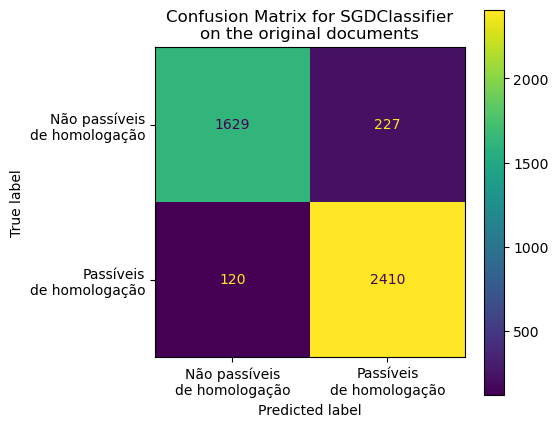

In [10]:
# vetorizar as palavras por contagem
vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=stop_words)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

docs = df_items[df_items['passivel_homologacao']<=1]['titulo']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

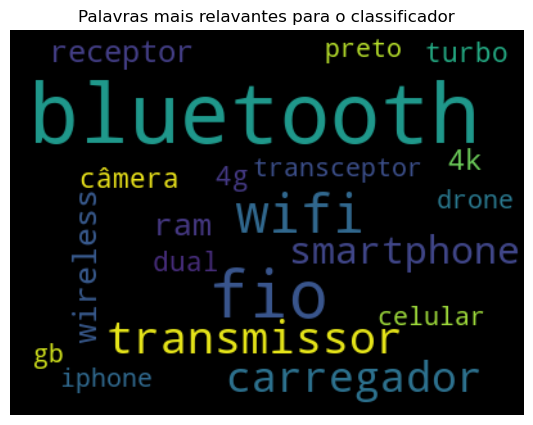

In [11]:
n_top_features = 20
label = target_names[-1]
feature_names = pipe['vectorizer'].get_feature_names_out()
X_train_count_vectors = pipe['vectorizer'].transform(X_train)
X_train_tfidf_vectors = pipe['transformer'].transform(X_train_count_vectors)
clf_coef = pipe['clf'].coef_
average_feature_effects = clf_coef * np.asarray(X_train_tfidf_vectors.mean(axis=0)).ravel()

top_indices = np.argsort(average_feature_effects[0])[-n_top_features:][::-1]
top = pd.DataFrame(feature_names[top_indices], columns=[label])
predictive_words = feature_names[top_indices]

top_featrues_frequency = {word:relevance for word,relevance in zip(predictive_words,average_feature_effects[0, top_indices])}
wc_top_featrues_frequency = WordCloud(height=300,random_state=100).generate_from_frequencies(top_featrues_frequency)
 
fig,ax = plt.subplots(1,1,figsize=(8,5))   
ax.imshow(wc_top_featrues_frequency, interpolation="bilinear")
ax.axis("off")
ax.set_title('Palavras mais relavantes para o classificador')
plt.show()

### Classificador com tokenizador customizado

Accuracy of SGD classifier on training set: 0.996
Accuracy of SGD classifier on test set: 0.920
AUC of SGD classifier on training set: 1.000
AUC of SGD classifier on test set: 0.972

                              precision    recall  f1-score   support

Não passíveis de homologação       0.93      0.88      0.90      1856
    Passíveis de homologação       0.91      0.95      0.93      2530

                    accuracy                           0.92      4386
                   macro avg       0.92      0.91      0.92      4386
                weighted avg       0.92      0.92      0.92      4386



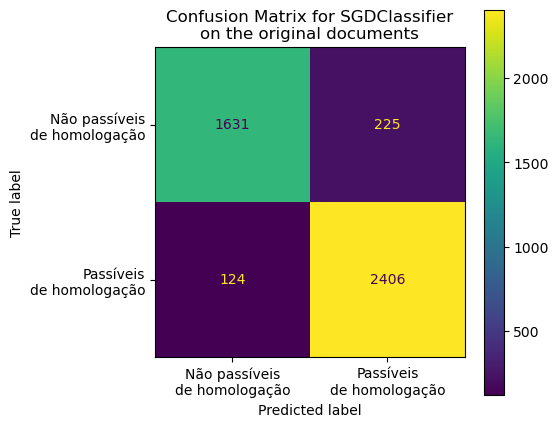

In [12]:
# vetorizar as palavras por contagem
tokenizer = lambda doc: clean_text(doc, return_tokens=True, nltk_tokenizer=False)
vectorizer = CountVectorizer(ngram_range=(1,2),tokenizer=tokenizer)

# transformar vetores aplicando TF-IDF
transformer = TfidfTransformer()

# classificardor SGD
clf = SGDClassifier(alpha=1e-5, loss='log_loss', penalty='l2')

# juntar tudo em pipeline
pipe = Pipeline(steps = [('vectorizer',vectorizer),('transformer',transformer),('clf',clf)])

docs = df_items[df_items['passivel_homologacao']<=1]['titulo']
labels = df_items[df_items['passivel_homologacao']<=1]['passivel_homologacao']

X_train, X_test, y_train, y_test = train_test_split(docs, labels, test_size=0.25, random_state=123)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X_train,y_train)

predicted = pipe.predict(X_test)

print('Accuracy of SGD classifier on training set: {:.3f}'
     .format(pipe.score(X_train, y_train)))
print('Accuracy of SGD classifier on test set: {:.3f}'
     .format(pipe.score(X_test, y_test)))
print('AUC of SGD classifier on training set: {:.3f}'
     .format(roc_auc_score(y_train,pipe.predict_proba(X_train)[:,1])))
print('AUC of SGD classifier on test set: {:.3f}'
     .format(roc_auc_score(y_test,pipe.predict_proba(X_test)[:,1])))

print()
print(classification_report(y_test, predicted, target_names=target_names))

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(y_test, predicted, ax=ax)
ax.xaxis.set_ticklabels(target_names_confusion)
ax.yaxis.set_ticklabels(target_names_confusion)
_ = ax.set_title(f"Confusion Matrix for {pipe['clf'].__class__.__name__}\non the original documents")

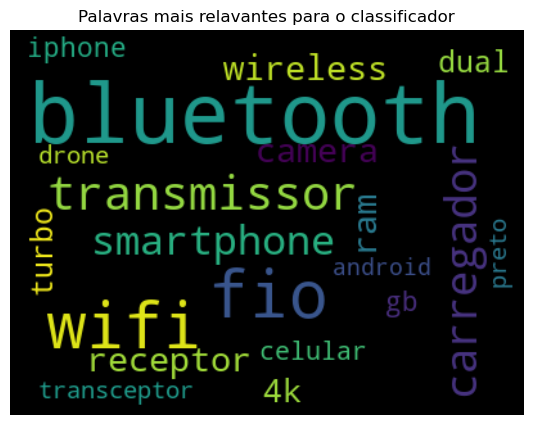

In [13]:
n_top_features = 20
label = target_names[-1]
feature_names = pipe['vectorizer'].get_feature_names_out()
X_train_count_vectors = pipe['vectorizer'].transform(X_train)
X_train_tfidf_vectors = pipe['transformer'].transform(X_train_count_vectors)
clf_coef = pipe['clf'].coef_
average_feature_effects = clf_coef * np.asarray(X_train_tfidf_vectors.mean(axis=0)).ravel()

top_indices = np.argsort(average_feature_effects[0])[-n_top_features:][::-1]
top = pd.DataFrame(feature_names[top_indices], columns=[label])
predictive_words = feature_names[top_indices]

top_featrues_frequency = {word:relevance for word,relevance in zip(predictive_words,average_feature_effects[0, top_indices])}
wc_top_featrues_frequency = WordCloud(height=300,random_state=100).generate_from_frequencies(top_featrues_frequency)
 
fig,ax = plt.subplots(1,1,figsize=(8,5))   
ax.imshow(wc_top_featrues_frequency, interpolation="bilinear")
ax.axis("off")
ax.set_title('Palavras mais relavantes para o classificador')
plt.show()

In [14]:
predictive_words

array(['bluetooth', 'fio', 'wifi', 'transmissor', 'carregador',
       'smartphone', 'ram', 'wireless', 'receptor', 'camera', '4k',
       'dual', 'turbo', 'gb', 'iphone', 'celular', 'transceptor', 'preto',
       'drone', 'android'], dtype=object)

**Resultados**

A tabela abaixo apresenta os resultados obtidos com variações do tokenizador customizado

| | Tokenizador Completo | Removida stopword "sem" | Sem regularizar wi-fi | Sem regularizar 2.4/5.8 | Regularizar wi-fi, sem regularizar 2.4/5.8 | Regularizar wi-fi e 2.4/5.8 |
| -- | -- | -- | -- | -- | -- | -- |
| | 0.939 | 0.939 | 0.939 | 0.938 | 0.938 | 0.940 |
| 1 | bluetooth | bluetooth | bluetooth | bluetooth | bluetooth | bluetooth |
| 2 | wifi | wifi | fio | fio | wifi | wifi |
| 3 | sem | fio | wifi | wifi | fio | fio  |
| 4 | fio | transmissor | transmissor | transmissor | transmissor | transmissor |
| 5 | sem fio | carregador | carregador | carregador | carregador | carregador |
| 6 | carregador | receptor | receptor | receptor | receptor | receptor |
| 7 | transmissor | smartphone | smartphone | smartphone | smartphone | smartphone |
| 8 | receptor | bateria | wi-fi | wi-fi | bateria | bateria |
| 9 | smartphone | 4k | bateria | bateria | 4k | 4k |
| 10 | bateria | ram | 4k | 4k | ram | usb |

A partir desse ponto, prosseguir os experimentos com tokenizador customizado com regularização de wi-fi e 2.4/5.8 e tokenizador utilizando o padrão do CountVectorizer do Scikit-learn.

Experimentar se a retirada de *stop words* específicas do domínio, como por exemplo as palavras ram, 4k, usb, etc. que não discriminam produtos passíveis de homologação, resultará em melhora de desempenho do classificador.